In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from openpyxl import Workbook
from openpyxl.drawing.image import Image
import openpyxl
from openpyxl.chart import LineChart, Reference
from openpyxl.styles import Font, PatternFill, Alignment
import os

# --- 1. SETUP: Load Data and Clean ---
try:
    data = pd.read_csv("Sample_Data.csv")
    data.rename(columns={'Values': 'Voltage'}, inplace=True)
    data['Time'] = pd.to_datetime(data['Timestamp'], format='%d-%m-%Y %H:%M:%S')
    data.set_index('Time', inplace=True)
except Exception as e:
    print(f"ERROR: Could not load data. {e}")
    exit()

# --- 2. TRENDLINES: Calculate Rolling Averages (MAs) ---
data['Short_Trend'] = data['Voltage'].rolling(window=1000, center=True).mean()
data['Long_Trend'] = data['Voltage'].rolling(window=5000, center=True).mean()

# --- 3. CREATE PNG CHART (as per your specifications) ---
def create_png_chart(df):
    """Creates PNG chart matching the specified format"""
    plt.figure(figsize=(14, 8))
    
    # Plot data as per specifications
    plt.plot(df.index, df['Voltage'], label='Original Value', color='black', alpha=0.7, linewidth=1)
    plt.plot(df.index, df['Short_Trend'], label='1000 Value', color='red', linewidth=2)
    plt.plot(df.index, df['Long_Trend'], label='5000 Value', color='blue', linewidth=2)
    
    # Formatting as per specifications
    plt.title('Values with 1000 and 5000 Value Moving Averages', fontsize=16, fontweight='bold')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Set y-axis limits as shown in specifications
    plt.ylim(30, 90)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the chart
    png_filename = "voltage_analysis_chart.png"
    plt.savefig(png_filename, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"[SUCCESS] PNG chart saved as {png_filename}")
    return png_filename

# Create the PNG chart
png_file = create_png_chart(data)

# --- 4. CREATE EXCEL DASHBOARD ---
def create_excel_dashboard(df, png_path):
    """Creates an Excel dashboard with charts and analysis"""
    
    # Create workbook
    wb = Workbook()
    
    # Remove default sheet and create custom ones
    wb.remove(wb.active)
    
    # Sheet 1: Dashboard
    dashboard_ws = wb.create_sheet("Dashboard", 0)
    
    # Add title and header
    dashboard_ws.merge_cells('A1:H1')
    dashboard_ws['A1'] = "Battery Voltage Analysis Dashboard"
    dashboard_ws['A1'].font = Font(size=18, bold=True, color="FFFFFF")
    dashboard_ws['A1'].fill = PatternFill(start_color="366092", end_color="366092", fill_type="solid")
    dashboard_ws['A1'].alignment = Alignment(horizontal='center')
    
    # Add the PNG image to dashboard
    img = Image(png_path)
    img.width = 600
    img.height = 400
    dashboard_ws.add_image(img, 'A3')
    
    # Add summary statistics
    dashboard_ws['A45'] = "Summary Statistics"
    dashboard_ws['A45'].font = Font(size=14, bold=True)
    
    stats_data = [
        ["Metric", "Value"],
        ["Total Data Points", len(df)],
        ["Average Voltage", f"{df['Voltage'].mean():.2f}"],
        ["Max Voltage", f"{df['Voltage'].max():.2f}"],
        ["Min Voltage", f"{df['Voltage'].min():.2f}"],
        ["Voltage Range", f"{df['Voltage'].max() - df['Voltage'].min():.2f}"],
        ["Data Start", df.index[0].strftime('%Y-%m-%d')],
        ["Data End", df.index[-1].strftime('%Y-%m-%d')]
    ]
    
    for i, row in enumerate(stats_data):
        for j, value in enumerate(row):
            cell = dashboard_ws.cell(row=46+i, column=1+j)
            cell.value = value
            if i == 0:  # Header row
                cell.font = Font(bold=True)
                cell.fill = PatternFill(start_color="D9E1F2", end_color="D9E1F2", fill_type="solid")
    
    # Sheet 2: Raw Data with Excel Charts
    data_ws = wb.create_sheet("Data Analysis", 1)
    
    # Prepare data for Excel
    sample_data = df.reset_index().iloc[::100]  # Sample every 100th point for performance
    
    # Add headers
    headers = ['Time', 'Original Value', '1000 MA', '5000 MA']
    for col, header in enumerate(headers, 1):
        cell = data_ws.cell(row=1, column=col)
        cell.value = header
        cell.font = Font(bold=True)
        cell.fill = PatternFill(start_color="D9E1F2", end_color="D9E1F2", fill_type="solid")
    
    # Add data
    for idx, (_, row) in enumerate(sample_data.iterrows(), 2):
        data_ws.cell(row=idx, column=1).value = row['Time']
        data_ws.cell(row=idx, column=2).value = row['Voltage']
        data_ws.cell(row=idx, column=3).value = row['Short_Trend']
        data_ws.cell(row=idx, column=4).value = row['Long_Trend']
    
    # Create Excel chart
    chart = LineChart()
    chart.title = "Voltage Analysis with Moving Averages"
    chart.style = 2
    chart.height = 15
    chart.width = 30
    
    # Add data to chart
    data_ref = Reference(data_ws, min_col=2, min_row=1, max_col=4, max_row=len(sample_data)+1)
    categories_ref = Reference(data_ws, min_col=1, min_row=2, max_row=len(sample_data)+1)
    
    chart.add_data(data_ref, titles_from_data=True)
    chart.set_categories(categories_ref)
    
    # Position chart
    data_ws.add_chart(chart, "F2")
    
    # Sheet 3: Peak Analysis
    peaks_ws = wb.create_sheet("Peak Analysis", 2)
    peaks_ws.title = "Peak Analysis"
    
    # Find peaks and valleys
    smooth_voltage = df['Short_Trend'].dropna()
    peaks_indices, _ = find_peaks(smooth_voltage, height=90, distance=50000)
    lows_indices, _ = find_peaks(-smooth_voltage, height=-50, distance=50000)
    
    peaks_table = smooth_voltage.iloc[peaks_indices].reset_index().rename(columns={'Short_Trend': 'Peak Voltage'})
    lows_table = smooth_voltage.iloc[lows_indices].reset_index().rename(columns={'Short_Trend': 'Low Voltage'})
    
    # Add peaks data
    peaks_ws['A1'] = "Voltage Peaks (High Points)"
    peaks_ws['A1'].font = Font(size=14, bold=True)
    
    peak_headers = ['Time', 'Peak Voltage']
    for col, header in enumerate(peak_headers, 1):
        cell = peaks_ws.cell(row=2, column=col)
        cell.value = header
        cell.font = Font(bold=True)
    
    for idx, (_, row) in enumerate(peaks_table.iterrows(), 3):
        peaks_ws.cell(row=idx, column=1).value = row['Time']
        peaks_ws.cell(row=idx, column=2).value = row['Peak Voltage']
    
    # Add lows data
    peaks_ws['D1'] = "Voltage Lows (Valley Points)"
    peaks_ws['D1'].font = Font(size=14, bold=True)
    
    low_headers = ['Time', 'Low Voltage']
    for col, header in enumerate(low_headers, 1):
        cell = peaks_ws.cell(row=2, column=col+3)
        cell.value = header
        cell.font = Font(bold=True)
    
    for idx, (_, row) in enumerate(lows_table.iterrows(), 3):
        peaks_ws.cell(row=idx, column=4).value = row['Time']
        peaks_ws.cell(row=idx, column=5).value = row['Low Voltage']
    
    # Save the workbook
    excel_filename = "voltage_analysis_dashboard.xlsx"
    wb.save(excel_filename)
    
    print(f"[SUCCESS] Excel dashboard saved as {excel_filename}")
    return excel_filename

# Create Excel dashboard
excel_file = create_excel_dashboard(data, png_file)

# --- 5. ANALYSIS: Find Key Events ---
def find_peaks_and_lows_simple(df):
    """Finds the high and low points of the battery cycles."""
    smooth_voltage = df['Short_Trend'].dropna()
    peaks_indices, _ = find_peaks(smooth_voltage, height=90, distance=50000)
    lows_indices, _ = find_peaks(-smooth_voltage, height=-50, distance=50000)

    peaks_table = smooth_voltage.iloc[peaks_indices].reset_index().rename(columns={'Short_Trend': 'Peak Voltage'})
    lows_table = smooth_voltage.iloc[lows_indices].reset_index().rename(columns={'Short_Trend': 'Low Voltage'})

    print("\n--- Key Cycle Events: Peaks (Highs) ---")
    print(peaks_table[['Time', 'Peak Voltage']].to_markdown(index=False, floatfmt=".2f"))
    print("\n--- Key Cycle Events: Lows (Valleys) ---")
    print(lows_table[['Time', 'Low Voltage']].to_markdown(index=False, floatfmt=".2f"))

def find_critical_voltage(df):
    """Finds instances where voltage drops below 20 (critical safety level)."""
    critical_events = df[df['Voltage'] < 20].reset_index()

    print("\n--- Critical Events: Voltage Below 20 ---")
    if critical_events.empty:
        print("GOOD: No instance found where the voltage dropped below 20V.")
    else:
        print(critical_events[['Time', 'Voltage']].head(10).to_markdown(index=False))

# Run analysis
find_peaks_and_lows_simple(data)
find_critical_voltage(data)

print(f"\n[SUMMARY]")
print(f"✅ PNG Chart: {png_file}")
print(f"✅ Excel Dashboard: {excel_file}")
print(f"✅ Analysis complete!")

[SUCCESS] PNG chart saved as voltage_analysis_chart.png
[SUCCESS] Excel dashboard saved as voltage_analysis_dashboard.xlsx

--- Key Cycle Events: Peaks (Highs) ---
| Time   | Peak Voltage   |
|--------|----------------|

--- Key Cycle Events: Lows (Valleys) ---
| Time                |   Low Voltage |
|:--------------------|--------------:|
| 2024-06-26 19:15:40 |         41.64 |

--- Critical Events: Voltage Below 20 ---
GOOD: No instance found where the voltage dropped below 20V.

[SUMMARY]
✅ PNG Chart: voltage_analysis_chart.png
✅ Excel Dashboard: voltage_analysis_dashboard.xlsx
✅ Analysis complete!


🔋 BATTERY VOLTAGE ANALYSIS SYSTEM
Available columns: ['Values', 'Timestamp']
Using 'Values' as voltage column
Using 'Timestamp' as timestamp column
✅ Data imported successfully: 21919 records
Date range: 2024-06-26 06:17:55 to 2024-07-03 10:30:42
Voltage range: 25.00 to 100.00
✅ 5-day moving average calculated


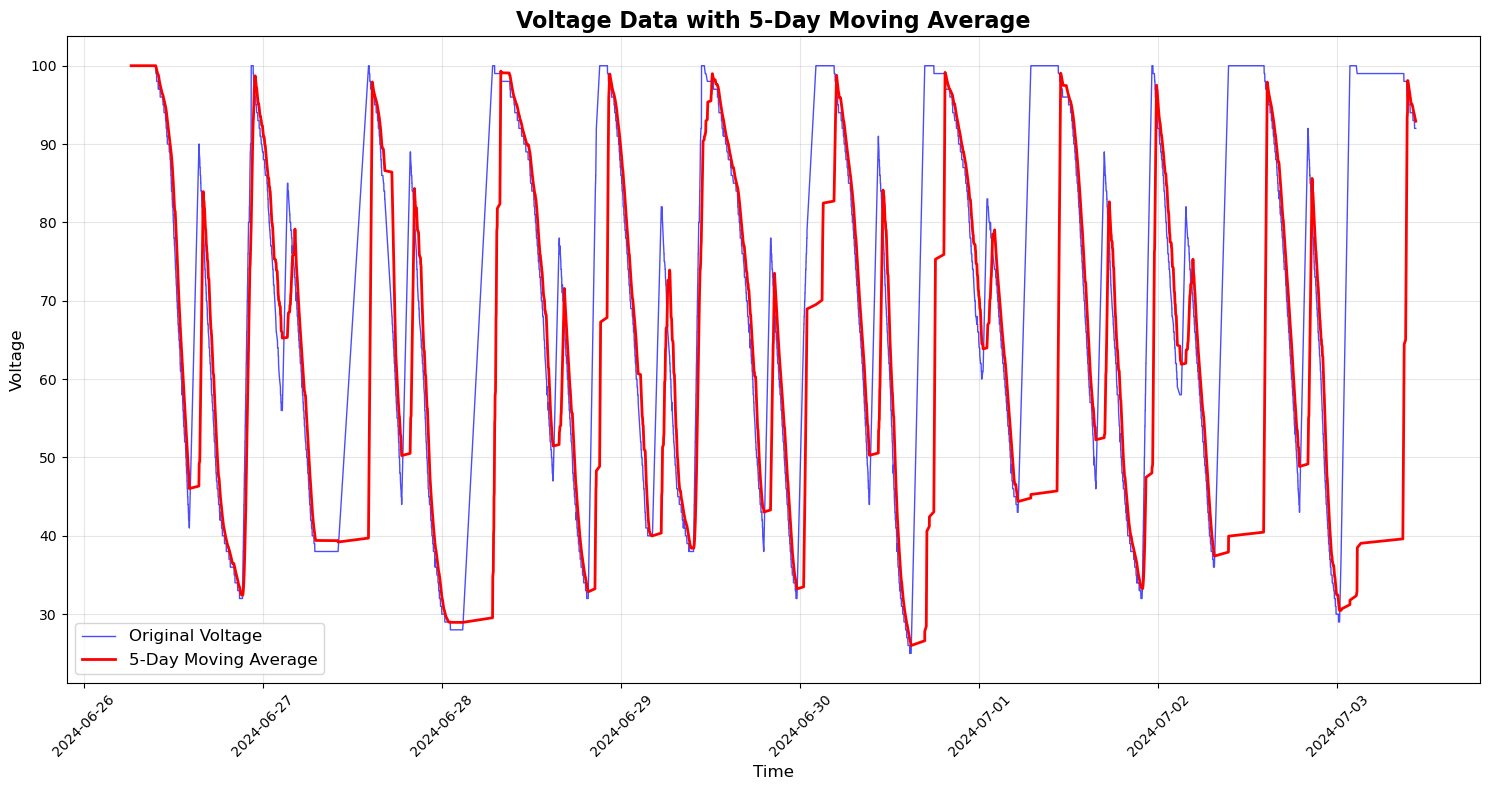

✅ Chart saved as 'voltage_analysis.png'
❌ Error finding peaks and lows: 'Time' is both an index level and a column label, which is ambiguous.

VOLTAGE BELOW 20 ANALYSIS
✅ GOOD: No instances found where voltage dropped below 20V

DOWNWARD ACCELERATION ANALYSIS
Found 11 downward acceleration events

Most significant acceleration points (steepest declines):
               Time  Voltage  slope  acceleration
2024-06-27 01:39:37       68   -3.0          -3.0
2024-06-27 17:15:03       68  -15.0         -15.0
2024-06-28 11:31:03       88   -1.0          -2.0
2024-06-29 02:35:10       52   -5.0          -5.0
2024-06-29 18:00:58       52   -3.0          -3.0
2024-06-30 06:06:41       88   -1.0          -2.0
2024-06-30 22:30:36       82   -1.0          -2.0
2024-07-01 15:32:08       47   -2.0          -2.0
2024-07-02 15:09:14       93   -1.0          -2.0
2024-07-03 02:38:03       99   -1.0          -1.0
2024-07-03 08:54:39       98   -1.0          -1.0
✅ Downward acceleration events saved to 'do

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')

class VoltageAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None
        self.peaks_df = None
        self.valleys_df = None
        self.low_voltage_events = None
        self.acceleration_events = None
        
    def import_data(self):
        """1a. Import data into pandas DataFrame"""
        try:
            # Read the CSV file
            self.df = pd.read_csv(self.file_path)
            
            # Display available columns to help with debugging
            print("Available columns:", self.df.columns.tolist())
            
            # Handle different possible column names
            voltage_col = None
            timestamp_col = None
            
            for col in self.df.columns:
                if 'volt' in col.lower() or 'value' in col.lower():
                    voltage_col = col
                if 'time' in col.lower() or 'date' in col.lower() or 'timestamp' in col.lower():
                    timestamp_col = col
            
            if voltage_col is None:
                voltage_col = self.df.columns[1] if len(self.df.columns) > 1 else self.df.columns[0]
            if timestamp_col is None:
                timestamp_col = self.df.columns[0]
            
            print(f"Using '{voltage_col}' as voltage column")
            print(f"Using '{timestamp_col}' as timestamp column")
            
            # Rename columns for consistency
            self.df = self.df.rename(columns={
                voltage_col: 'Voltage',
                timestamp_col: 'Timestamp'
            })
            
            # Convert timestamp to datetime
            self.df['Time'] = pd.to_datetime(self.df['Timestamp'], errors='coerce')
            
            # Drop rows with invalid timestamps
            initial_count = len(self.df)
            self.df = self.df.dropna(subset=['Time'])
            if len(self.df) < initial_count:
                print(f"Warning: Dropped {initial_count - len(self.df)} rows with invalid timestamps")
            
            self.df.set_index('Time', inplace=True)
            
            # Sort by time
            self.df = self.df.sort_index()
            
            print(f"✅ Data imported successfully: {len(self.df)} records")
            print(f"Date range: {self.df.index.min()} to {self.df.index.max()}")
            print(f"Voltage range: {self.df['Voltage'].min():.2f} to {self.df['Voltage'].max():.2f}")
            
            return True
            
        except Exception as e:
            print(f"❌ Error importing data: {e}")
            return False
    
    def calculate_moving_average(self, window_days=5):
        """1b. Calculate 5-day moving average"""
        try:
            # Assuming data is hourly, calculate window size
            hours_per_day = 24
            window_size = window_days * hours_per_day
            
            # Use center=False to avoid future data in average
            self.df['5_day_MA'] = self.df['Voltage'].rolling(
                window=window_size, 
                min_periods=1,
                center=False
            ).mean()
            
            print(f"✅ {window_days}-day moving average calculated")
            return True
            
        except Exception as e:
            print(f"❌ Error calculating moving average: {e}")
            return False
    
    def plot_chart(self):
        """1b. Plot chart with moving average"""
        try:
            plt.figure(figsize=(15, 8))
            
            # Plot original data
            plt.plot(self.df.index, self.df['Voltage'], 
                    label='Original Voltage', 
                    color='blue', 
                    alpha=0.7, 
                    linewidth=1)
            
            # Plot moving average
            if '5_day_MA' in self.df.columns:
                plt.plot(self.df.index, self.df['5_day_MA'], 
                        label='5-Day Moving Average', 
                        color='red', 
                        linewidth=2)
            
            # Formatting
            plt.title('Voltage Data with 5-Day Moving Average', fontsize=16, fontweight='bold')
            plt.xlabel('Time', fontsize=12)
            plt.ylabel('Voltage', fontsize=12)
            plt.legend(fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=45)
            plt.tight_layout()
            
            # Save the plot
            plt.savefig('voltage_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("✅ Chart saved as 'voltage_analysis.png'")
            return True
            
        except Exception as e:
            print(f"❌ Error plotting chart: {e}")
            return False
    
    def find_peaks_and_lows(self, distance_hours=24):
        """1c. Find local peaks and lows in the data"""
        try:
            # Use moving average for smoother peak detection
            if '5_day_MA' not in self.df.columns:
                self.calculate_moving_average()
                
            clean_data = self.df['5_day_MA'].dropna()
            
            if len(clean_data) == 0:
                print("❌ No data available for peak detection")
                return False
            
            # Auto-calculate height thresholds based on data
            mean_voltage = clean_data.mean()
            std_voltage = clean_data.std()
            
            # Find peaks (local maxima)
            peaks_idx, _ = find_peaks(
                clean_data, 
                height=mean_voltage + 0.5 * std_voltage,
                distance=distance_hours,
                prominence=0.5
            )
            
            # Find valleys (local minima)
            valleys_idx, _ = find_peaks(
                -clean_data, 
                height=-(mean_voltage - 0.5 * std_voltage),
                distance=distance_hours,
                prominence=0.5
            )
            
            # Create results DataFrames
            self.peaks_df = pd.DataFrame({
                'Time': clean_data.index[peaks_idx],
                'Voltage': clean_data.iloc[peaks_idx],
                'Type': 'Peak'
            })
            
            self.valleys_df = pd.DataFrame({
                'Time': clean_data.index[valleys_idx],
                'Voltage': clean_data.iloc[valleys_idx],
                'Type': 'Valley'
            })
            
            # Combine results
            extremes_df = pd.concat([self.peaks_df, self.valleys_df]).sort_values('Time').reset_index(drop=True)
            
            print("\n" + "="*50)
            print("LOCAL PEAKS AND LOWS")
            print("="*50)
            print(extremes_df.to_string(index=False))
            
            # Save to CSV
            extremes_df.to_csv('peaks_and_lows.csv', index=False)
            print("✅ Peaks and lows saved to 'peaks_and_lows.csv'")
            
            return True
            
        except Exception as e:
            print(f"❌ Error finding peaks and lows: {e}")
            return False
    
    def find_voltage_below_20(self):
        """1d. Find every instance where Voltage went below 20"""
        try:
            below_20 = self.df[self.df['Voltage'] < 20].copy()
            
            if below_20.empty:
                print("\n" + "="*50)
                print("VOLTAGE BELOW 20 ANALYSIS")
                print("="*50)
                print("✅ GOOD: No instances found where voltage dropped below 20V")
                self.low_voltage_events = pd.DataFrame()
                return True
            
            # Group consecutive events (events within 2 hours are considered same event)
            below_20['time_diff'] = below_20.index.to_series().diff() > timedelta(hours=2)
            below_20['event_group'] = below_20['time_diff'].cumsum()
            
            # Summarize each event
            event_summary = below_20.groupby('event_group').agg({
                'Voltage': ['min', 'count', 'mean'],
                'Time': ['first', 'last']
            }).round(2)
            
            # Flatten column names
            event_summary.columns = ['Min_Voltage', 'Duration_Records', 'Mean_Voltage', 'Start_Time', 'End_Time']
            event_summary = event_summary.reset_index(drop=True)
            
            # Calculate event duration
            event_summary['Duration_Hours'] = (event_summary['End_Time'] - event_summary['Start_Time']).dt.total_seconds() / 3600
            
            self.low_voltage_events = event_summary
            
            print("\n" + "="*50)
            print("VOLTAGE BELOW 20 ANALYSIS")
            print("="*50)
            print(f"⚠️  Found {len(event_summary)} events where voltage dropped below 20V")
            print("\nEvent Summary:")
            print(event_summary[['Start_Time', 'Min_Voltage', 'Duration_Hours', 'Duration_Records']].to_string(index=False))
            
            # Save to CSV
            below_20[['Voltage']].to_csv('voltage_below_20_instances.csv')
            event_summary.to_csv('voltage_below_20_events.csv', index=False)
            print("✅ Low voltage events saved to CSV files")
            
            return True
            
        except Exception as e:
            print(f"❌ Error finding voltage below 20: {e}")
            return False
    
    def find_downward_acceleration(self, window=6):
        """2. Bonus: Find downward slope acceleration in each downward cycle"""
        try:
            # Calculate first derivative (slope)
            self.df['slope'] = self.df['Voltage'].diff()
            
            # Calculate second derivative (acceleration)
            self.df['acceleration'] = self.df['slope'].diff()
            
            # Find significant downward acceleration events
            # Criteria: strong negative acceleration during downward trend
            acceleration_threshold = self.df['acceleration'].quantile(0.1)  # Bottom 10%
            
            downward_accel = self.df[
                (self.df['acceleration'] < acceleration_threshold) &
                (self.df['slope'] < 0) &  # Currently in downward trend
                (self.df['acceleration'].abs() > 0.01)  # Significant change
            ].copy()
            
            if downward_accel.empty:
                print("\n" + "="*60)
                print("DOWNWARD ACCELERATION ANALYSIS")
                print("="*60)
                print("No significant downward acceleration events found")
                self.acceleration_events = pd.DataFrame()
                return True
            
            # Group consecutive acceleration events
            downward_accel['time_diff'] = downward_accel.index.to_series().diff() > timedelta(hours=2)
            downward_accel['accel_group'] = downward_accel['time_diff'].cumsum()
            
            # Get the most significant point from each acceleration event
            significant_accel = downward_accel.loc[
                downward_accel.groupby('accel_group')['acceleration'].idxmin()
            ]
            
            # Clean up results for display
            self.acceleration_events = significant_accel[['slope', 'acceleration', 'Voltage']].round(4)
            self.acceleration_events['Time'] = significant_accel.index
            
            print("\n" + "="*60)
            print("DOWNWARD ACCELERATION ANALYSIS")
            print("="*60)
            print(f"Found {len(significant_accel)} downward acceleration events")
            print("\nMost significant acceleration points (steepest declines):")
            print(self.acceleration_events[['Time', 'Voltage', 'slope', 'acceleration']].head(20).to_string(index=False))
            
            # Save to CSV
            self.acceleration_events.to_csv('downward_acceleration.csv', index=False)
            print("✅ Downward acceleration events saved to 'downward_acceleration.csv'")
            
            return True
            
        except Exception as e:
            print(f"❌ Error finding downward acceleration: {e}")
            return False
    
    def generate_summary_report(self):
        """Generate comprehensive summary report"""
        print("\n" + "="*70)
        print("COMPREHENSIVE ANALYSIS SUMMARY")
        print("="*70)
        
        print(f"📊 Data Overview:")
        print(f"   • Total records: {len(self.df):,}")
        print(f"   • Date range: {self.df.index.min()} to {self.df.index.max()}")
        print(f"   • Voltage range: {self.df['Voltage'].min():.2f}V - {self.df['Voltage'].max():.2f}V")
        print(f"   • Average voltage: {self.df['Voltage'].mean():.2f}V")
        
        print(f"\n📈 Cycle Analysis:")
        print(f"   • Peaks detected: {len(self.peaks_df) if self.peaks_df is not None else 0}")
        print(f"   • Valleys detected: {len(self.valleys_df) if self.valleys_df is not None else 0}")
        
        print(f"\n⚠️  Safety Events:")
        low_voltage_count = len(self.low_voltage_events) if self.low_voltage_events is not None and not self.low_voltage_events.empty else 0
        print(f"   • Voltage < 20V events: {low_voltage_count}")
        
        print(f"\n📉 Trend Analysis:")
        accel_count = len(self.acceleration_events) if self.acceleration_events is not None and not self.acceleration_events.empty else 0
        print(f"   • Downward acceleration events: {accel_count}")
        
        print(f"\n💾 Files Generated:")
        print("   • voltage_analysis.png - Main analysis chart")
        print("   • peaks_and_lows.csv - Peak and valley timestamps")
        if low_voltage_count > 0:
            print("   • voltage_below_20_instances.csv - All instances below 20V")
            print("   • voltage_below_20_events.csv - Grouped low voltage events")
        if accel_count > 0:
            print("   • downward_acceleration.csv - Acceleration analysis")
        
        print("\n" + "="*70)

def main():
    """Main execution function"""
    
    # File path - UPDATE THIS TO YOUR ACTUAL FILE PATH
    file_path = "Sample_Data.csv"  # Change this to your file path
    
    print("🔋 BATTERY VOLTAGE ANALYSIS SYSTEM")
    print("="*50)
    
    # Initialize analyzer
    analyzer = VoltageAnalyzer(file_path)
    
    # 1a. Import data
    if not analyzer.import_data():
        return
    
    # 1b. Calculate moving average and plot
    analyzer.calculate_moving_average()
    analyzer.plot_chart()
    
    # 1c. Find peaks and lows
    analyzer.find_peaks_and_lows()
    
    # 1d. Find voltage below 20
    analyzer.find_voltage_below_20()
    
    # 2. Bonus: Find downward acceleration
    analyzer.find_downward_acceleration()
    
    # Generate final summary
    analyzer.generate_summary_report()

if __name__ == "__main__":
    main()